# 녹조와 전력사용 파악하기
## 녹조와 전력의 상관관계 파악 후 예측모델 및 아두이노 구현

In [74]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial Unicode MS'


In [75]:
import pandas as pd

# CSV 파일 불러오기
data = pd.read_csv(r"C:\Users\82103\Downloads\15-18red_tide_data.csv", encoding='euc-kr')
df = data.copy()

# 데이터 확인
df


발생날짜                                               조사해역  \
0     20181204                                         경남 통영시 영운리   
1     20181019                                             경남 거제시   
2     20180928                                             전남 완도군   
3     20180922                                             전남 장흥군   
4     20180920                                         전남 신안군 흑산면   
...        ...                                                ...   
2378  20150508  가덕도(기도원앞)~가덕도(기도원앞),몰운대 앞~몰운대 앞,오륙도 인근~오륙도 인근,...   
2379  20150430                                    속천항 일대, 가조도~칠천도   
2380  20150416                                     통영시 산양 풍화명지~한산   
2381  20150409                                            통영시 원문만   
2382  20150309                                      포항시 형산대교~연일대교   

                            원인생물  생물밀도(max)  생물밀도(min)  수온(max)  수온(min)  \
0             Akashiwo sanguinea     1000.0      800.0     15.5     15.5   
1              Mesodinium rubrum      480.0      260.0     20.2     20.2   
2              Mesodinium rubrum     3500.0     2000.0      0.0      0.0   
3              Mesodinium rubrum     4000.0     1000.0     23.5     22.7   
4                  Noctiluca sp.     1532.0     1500.0     22.8     21.8   
...                          ...        ...        ...      ...      ...   
2378          Akashiwo sanguinea      325.0        1.0     17.2     12.9   
2379          Akashiwo sanguinea     6000.0     5500.0     15.4     14.4   
2380  Cochlodinium polykrikoides     1000.0      100.0     22.0     21.0   
2381          Akashiwo sanguinea      500.0      400.0     12.8     12.8   
2382            Cryptomonas  sp.        NaN    15000.0  20000.0      7.1   

              속보코드  
0     20181204-001  
1     20181024-002  
2     20181001-001  
3     20180927-001  
4     20180921-007  
...            ...  
2378    2015050801  
2379    2015043001  
2380    2015041601  
2381    2015040901  
2382    2015030901  

[2383 rows x 8 columns]

In [76]:
df.isnull().sum()


발생날짜          0
조사해역          0
원인생물          1
생물밀도(max)    64
생물밀도(min)    51
수온(max)      41
수온(min)      36
속보코드          0
dtype: int64

In [77]:
# '특정컬럼'에 결측치가 있는 데이터 삭제
df.dropna(subset=['원인생물'], inplace=True)

In [78]:
df.isnull().sum()

발생날짜          0
조사해역          0
원인생물          0
생물밀도(max)    64
생물밀도(min)    51
수온(max)      41
수온(min)      36
속보코드          0
dtype: int64

In [79]:
# 각 컬럼별 결측치 개수 계산
missing_values = df.isnull().sum()

# 결측치 비율 계산
missing_ratio = missing_values / len(df) * 100
missing_ratio

발생날짜         0.000000
조사해역         0.000000
원인생물         0.000000
생물밀도(max)    2.686818
생물밀도(min)    2.141058
수온(max)      1.721243
수온(min)      1.511335
속보코드         0.000000
dtype: float64

### 1. 녹조에 영향을 주는 요소들에 대해 파악하기

### 1) 녹조의 종류 파악하기


In [80]:
# 녹조의 종류, 가장 많은 녹조 파악하기
cause_counts = data['원인생물'].value_counts()
cause_counts

Cochlodinium polykrikoides    2078
Akashiwo sanguinea              59
없음                              54
Alexandrium sp.                 51
Leptocylindrus danicus          24
Chaetoceros curvisetus          24
Prorocentrum dentatum           13
Heterosigma akashiwo            12
Noctiluca sp.                    8
Alexandrium catenella            8
Alexandrium affine               8
Nitzschia pungens                8
Cochlodinium sp.                 8
Mesodinium rubrum                7
Chaetoceros spp.                 3
미 확인                             2
Cryptomonas  sp.                 2
Pheopolykrikos hartmannii        2
Gymnodinium catenatum            1
Prorodon sp.                     1
Chattonella marina               1
Ceratium furca                   1
Pyramimonas sp.                  1
Gymnodinium sp.                  1
Scrippsiella trochoidea          1
Karenia mikimotoi                1
Prorocentrum minimum             1
Ceratium fusus                   1
Prorocentrum micans 

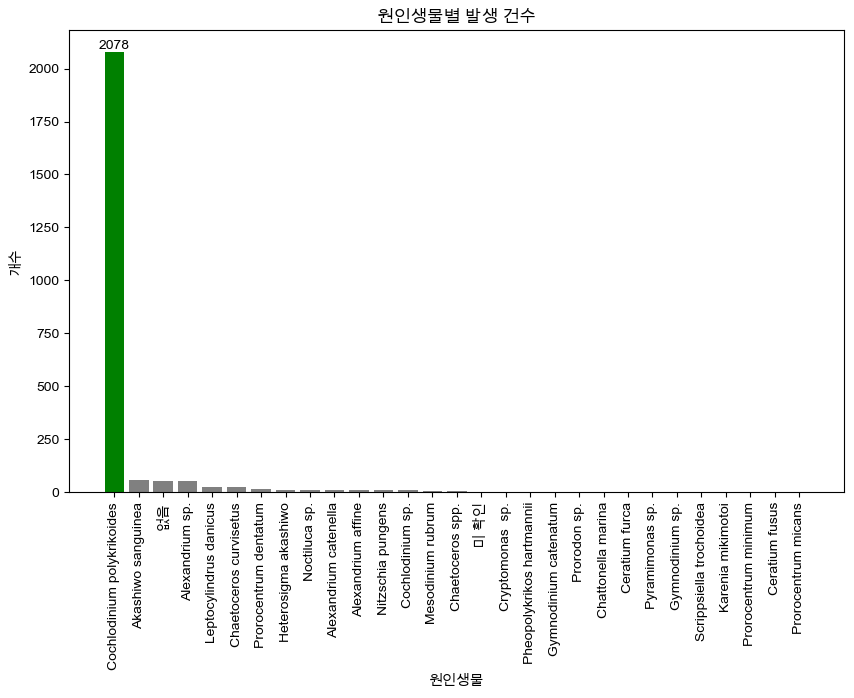

In [81]:
import matplotlib.pyplot as plt

# '원인생물' 컬럼의 각 항목별 개수 세기
cause_counts = df['원인생물'].value_counts()

# 일정 값 이상인 차트에 색상 지정
threshold = 100
colors = ['green' if count >= threshold else 'gray' for count in cause_counts]

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(cause_counts.index, cause_counts.values, color=colors)
plt.xlabel('원인생물')
plt.ylabel('개수')
plt.title('원인생물별 발생 건수')

# x축 눈금 텍스트를 90도 회전
plt.xticks(rotation=90)

# 일정 값 이상인 항목에만 색상 표시
for i, count in enumerate(cause_counts):
    if count >= threshold:
        plt.text(i, count, str(count), ha='center', va='bottom', color='black')

plt.show()


## 2. Cochlodinium에 대해서 상세 파악하기

### 1)  Cochlodinium 데이터 프레임 구성

In [114]:
# Cochlodinium 데이터 프레임 구성
# 원인 생물이 'Cochlodinium polykrikoides'인 데이터 추출
filtered_data = data[data['원인생물'] == 'Cochlodinium polykrikoides']
filtered_data

발생날짜                                    조사해역  \
21    20180809                      전남 여수시 돌산동안, 월호~화태   
22    20180808                전남 여수시 돌산동안, 월호~화태~함구미해역   
23    20180808                전남 여수시 돌산동안, 월호~화태~함구미해역   
24    20180808                              경남 고성군 하이면   
25    20180808                              경남 고성군 하이면   
...        ...                                     ...   
2344  20150804  경남 통영시 산양 오비 ~ 삼덕 ~ 곤리 , 비진도 ~ 용초도~장사도   
2345  20150804  경남 통영시 산양 오비 ~ 삼덕 ~ 곤리 , 비진도 ~ 용초도~장사도   
2346  20150803           경남 통영시 산양 오비도~곤리, 추도, 비진도~오곡도   
2347  20150802      통영시 추도-산양 연명, 통영시 비진도-오곡도, 거제시 장사도   
2380  20150416                          통영시 산양 풍화명지~한산   

                            원인생물  생물밀도(max)  생물밀도(min)  수온(max)  수온(min)  \
21    Cochlodinium polykrikoides      930.0       90.0     39.8     28.6   
22    Cochlodinium polykrikoides      500.0      400.0     29.3     27.5   
23    Cochlodinium polykrikoides      960.0       10.0     29.3     27.5   
24    Cochlodinium polykrikoides      500.0      400.0     30.1     30.1   
25    Cochlodinium polykrikoides      960.0       10.0     30.1     30.1   
...                          ...        ...        ...      ...      ...   
2344  Cochlodinium polykrikoides      650.0       30.0     25.6     19.6   
2345  Cochlodinium polykrikoides      360.0        1.0     25.6     19.6   
2346  Cochlodinium polykrikoides      500.0        5.0     25.6     21.2   
2347  Cochlodinium polykrikoides       50.0        5.0     25.4     20.5   
2380  Cochlodinium polykrikoides     1000.0      100.0     22.0     21.0   

              속보코드  
21    20180809-001  
22    20180808-001  
23    20180808-001  
24    20180808-001  
25    20180808-001  
...            ...  
2344    2015080401  
2345    2015080401  
2346    2015080301  
2347    2015080201  
2380    2015041601  

[2078 rows x 8 columns]

In [115]:
# 공백을 기준으로 조사해역 주소를 나누고, 최대 3개까지만 추출하여 '시군구' 컬럼에 할당
filtered_data['시군구'] = filtered_data['조사해역'].str.split().str[:3].str.join(' ')
# '시군구' 컬럼 값 중에서 쉼표(,) 제거
filtered_data['시군구'] = filtered_data['시군구'].str.replace(',', '')
filtered_data['시군구'] = filtered_data['시군구'].str.replace('~', ' ')
filtered_data['시군구'] = filtered_data['시군구'].str.replace('∼', ' ')
filtered_data['시군구'] = filtered_data['시군구'].str.replace('.', ' ')
filtered_data['시군구'] = filtered_data['시군구'].str.replace('-', ' ')
filtered_data['시군구'] = filtered_data['시군구'].str.replace('(', ' ')
filtered_data['시군구'] = filtered_data['시군구'].str.replace(')', ' ')
filtered_data['시군구'] = filtered_data['시군구'].str.split().str[:2].str.join(' ')
filtered_data

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\1753074591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['시군구'] = filtered_data['조사해역'].str.split().str[:3].str.join(' ')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\1753074591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['시군구'] = filtered_data['시군구'].str.replace(',', '')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\1753074591.py:5: SettingWithCopyWarning: 
A value is trying

발생날짜                                    조사해역  \
21    20180809                      전남 여수시 돌산동안, 월호~화태   
22    20180808                전남 여수시 돌산동안, 월호~화태~함구미해역   
23    20180808                전남 여수시 돌산동안, 월호~화태~함구미해역   
24    20180808                              경남 고성군 하이면   
25    20180808                              경남 고성군 하이면   
...        ...                                     ...   
2344  20150804  경남 통영시 산양 오비 ~ 삼덕 ~ 곤리 , 비진도 ~ 용초도~장사도   
2345  20150804  경남 통영시 산양 오비 ~ 삼덕 ~ 곤리 , 비진도 ~ 용초도~장사도   
2346  20150803           경남 통영시 산양 오비도~곤리, 추도, 비진도~오곡도   
2347  20150802      통영시 추도-산양 연명, 통영시 비진도-오곡도, 거제시 장사도   
2380  20150416                          통영시 산양 풍화명지~한산   

                            원인생물  생물밀도(max)  생물밀도(min)  수온(max)  수온(min)  \
21    Cochlodinium polykrikoides      930.0       90.0     39.8     28.6   
22    Cochlodinium polykrikoides      500.0      400.0     29.3     27.5   
23    Cochlodinium polykrikoides      960.0       10.0     29.3     27.5   
24    Cochlodinium polykrikoides      500.0      400.0     30.1     30.1   
25    Cochlodinium polykrikoides      960.0       10.0     30.1     30.1   
...                          ...        ...        ...      ...      ...   
2344  Cochlodinium polykrikoides      650.0       30.0     25.6     19.6   
2345  Cochlodinium polykrikoides      360.0        1.0     25.6     19.6   
2346  Cochlodinium polykrikoides      500.0        5.0     25.6     21.2   
2347  Cochlodinium polykrikoides       50.0        5.0     25.4     20.5   
2380  Cochlodinium polykrikoides     1000.0      100.0     22.0     21.0   

              속보코드     시군구  
21    20180809-001  전남 여수시  
22    20180808-001  전남 여수시  
23    20180808-001  전남 여수시  
24    20180808-001  경남 고성군  
25    20180808-001  경남 고성군  
...            ...     ...  
2344    2015080401  경남 통영시  
2345    2015080401  경남 통영시  
2346    2015080301  경남 통영시  
2347    2015080201  통영시 추도  
2380    2015041601  통영시 산양  

[2078 rows x 9 columns]

In [117]:
filtered_data['발생날짜'] = pd.to_datetime(filtered_data['발생날짜'], format='%Y%m%d')

# 발생일자로 그룹화하여 생물밀도의 평균 계산 후 새로운 컬럼 추가
filtered_data['생물밀도평균(mean)'] = filtered_data.groupby('발생날짜')['생물밀도(max)'].transform('mean')
filtered_data['수온평균(mean)'] = filtered_data.groupby('발생날짜')['수온(max)'].transform('mean')
# '특정컬럼' 값에 '남해'를 포함하는 데이터 삭제
#filtered_data = filtered_data[~filtered_data['시군구'].str.contains('남해')]


filtered_data

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3959570716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['발생날짜'] = pd.to_datetime(filtered_data['발생날짜'], format='%Y%m%d')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3959570716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['생물밀도평균(mean)'] = filtered_data.groupby('발생날짜')['생물밀도(max)'].transform('mean')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3959570716.py:5: SettingWithCop

발생날짜                                    조사해역  \
21   2018-08-09                      전남 여수시 돌산동안, 월호~화태   
22   2018-08-08                전남 여수시 돌산동안, 월호~화태~함구미해역   
23   2018-08-08                전남 여수시 돌산동안, 월호~화태~함구미해역   
24   2018-08-08                              경남 고성군 하이면   
25   2018-08-08                              경남 고성군 하이면   
...         ...                                     ...   
2344 2015-08-04  경남 통영시 산양 오비 ~ 삼덕 ~ 곤리 , 비진도 ~ 용초도~장사도   
2345 2015-08-04  경남 통영시 산양 오비 ~ 삼덕 ~ 곤리 , 비진도 ~ 용초도~장사도   
2346 2015-08-03           경남 통영시 산양 오비도~곤리, 추도, 비진도~오곡도   
2347 2015-08-02      통영시 추도-산양 연명, 통영시 비진도-오곡도, 거제시 장사도   
2380 2015-04-16                          통영시 산양 풍화명지~한산   

                            원인생물  생물밀도(max)  생물밀도(min)  수온(max)  수온(min)  \
21    Cochlodinium polykrikoides      930.0       90.0     39.8     28.6   
22    Cochlodinium polykrikoides      500.0      400.0     29.3     27.5   
23    Cochlodinium polykrikoides      960.0       10.0     29.3     27.5   
24    Cochlodinium polykrikoides      500.0      400.0     30.1     30.1   
25    Cochlodinium polykrikoides      960.0       10.0     30.1     30.1   
...                          ...        ...        ...      ...      ...   
2344  Cochlodinium polykrikoides      650.0       30.0     25.6     19.6   
2345  Cochlodinium polykrikoides      360.0        1.0     25.6     19.6   
2346  Cochlodinium polykrikoides      500.0        5.0     25.6     21.2   
2347  Cochlodinium polykrikoides       50.0        5.0     25.4     20.5   
2380  Cochlodinium polykrikoides     1000.0      100.0     22.0     21.0   

              속보코드     시군구  생물밀도평균(mean)  수온평균(mean)  
21    20180809-001  전남 여수시         930.0        39.8  
22    20180808-001  전남 여수시         730.0        29.7  
23    20180808-001  전남 여수시         730.0        29.7  
24    20180808-001  경남 고성군         730.0        29.7  
25    20180808-001  경남 고성군         730.0        29.7  
...            ...     ...           ...         ...  
2344    2015080401  경남 통영시         505.0        25.9  
2345    2015080401  경남 통영시         505.0        25.9  
2346    2015080301  경남 통영시         500.0        25.6  
2347    2015080201  통영시 추도          50.0        25.4  
2380    2015041601  통영시 산양        1000.0        22.0  

[2078 rows x 11 columns]

In [85]:
#filtered_data.to_csv("1.csv", index=False)



In [118]:
# 각 컬럼별 결측치 개수 계산
missing = filtered_data.isnull().sum()
missing

발생날짜             0
조사해역             0
원인생물             0
생물밀도(max)        0
생물밀도(min)        0
수온(max)         17
수온(min)         17
속보코드             0
시군구              0
생물밀도평균(mean)     0
수온평균(mean)       0
dtype: int64

In [119]:
# 결측치 삭제
filtered_data.dropna(subset=['수온(max)', '수온(min)'], inplace=True)
filtered_data.isnull().sum()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3285294300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=['수온(max)', '수온(min)'], inplace=True)


발생날짜            0
조사해역            0
원인생물            0
생물밀도(max)       0
생물밀도(min)       0
수온(max)         0
수온(min)         0
속보코드            0
시군구             0
생물밀도평균(mean)    0
수온평균(mean)      0
dtype: int64

In [136]:
import pandas as pd

# 발생일자를 날짜 형식으로 변환
filtered_data['발생날짜'] = pd.to_datetime(filtered_data['발생날짜'], format='%Y%m%d')

# 생물밀도평균(mean) 컬럼 계산
filtered_data['생물밀도평균(mean)'] = filtered_data['생물밀도(max)']

# 수온평균(mean) 컬럼 계산
filtered_data['수온평균(mean)'] = filtered_data['수온(max)']


mean_data


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3588425226.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3588425226.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3588425226.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

생물밀도평균(mean)  수온평균(mean)       발생날짜     년   월   일
21      930.000000   39.800000 2018-08-09  2018  08  09
22      730.000000   29.700000 2018-08-08  2018  08  08
26      726.000000   29.260000 2018-08-07  2018  08  07
51      275.000000   29.750000 2018-08-06  2018  08  06
55      390.000000   28.166667 2018-08-05  2018  08  05
64      583.333333   29.033333 2018-08-04  2018  08  04
73     1053.333333   27.966667 2018-08-03  2018  08  03
82     1310.000000   28.775000 2018-08-02  2018  08  02
98     1115.000000   28.200000 2018-08-01  2018  08  01
134     917.600000   27.300000 2018-07-31  2018  07  31
159    1707.692308   26.807692 2018-07-30  2018  07  30
172    1423.333333   27.600000 2018-07-29  2018  07  29
181    1890.000000   27.650000 2018-07-28  2018  07  28
185    1916.666667   29.666667 2018-07-27  2018  07  27
194     405.000000   28.633333 2018-07-26  2018  07  26
203     526.666667   28.533333 2018-07-25  2018  07  25
212     249.000000   28.550000 2018-07-24  2018  07  24
228     555.500000   27.200000 2018-07-23  2018  07  23
324     355.000000   22.525000 2018-07-03  2018  07  03
503    2983.513514   24.113514 2015-09-09  2015  09  09
540    2410.000000   24.412500 2015-09-08  2015  09  08
604    3408.040000   24.430000 2015-09-07  2015  09  07
654    2628.571429   24.985714 2015-09-06  2015  09  06
703    2435.428571   24.642857 2015-09-05  2015  09  05
752    2647.750000   25.525000 2015-09-04  2015  09  04
816    5272.333333   25.183333 2015-09-03  2015  09  03
852    1721.428571   25.157143 2015-09-02  2015  09  02
901    2419.000000   25.116667 2015-09-01  2015  09  01
940    2016.666667   24.866667 2015-08-31  2015  08  31
976    3531.666667   25.233333 2015-08-30  2015  08  30
1012   1985.714286   25.128571 2015-08-29  2015  08  29
1061   2977.500000   25.300000 2015-08-28  2015  08  28
1125   3388.571429   25.400000 2015-08-27  2015  08  27
1174   2362.500000   24.900000 2015-08-26  2015  08  26
1247    753.333333   24.537500 2015-08-25  2015  08  25
1319   1798.888889   25.177778 2015-08-24  2015  08  24
1400   6845.000000   25.825000 2015-08-23  2015  08  23
1464   6653.750000   25.475000 2015-08-22  2015  08  22
1528   4750.000000   25.025000 2015-08-21  2015  08  21
1592   7935.000000   25.287500 2015-08-20  2015  08  20
1656   6611.750000   25.225000 2015-08-19  2015  08  19
1720   2505.750000   25.225000 2015-08-18  2015  08  18
1784   3667.500000   25.525000 2015-08-17  2015  08  17
1848   2395.333333   25.183333 2015-08-16  2015  08  16
1884   3131.000000   25.266667 2015-08-15  2015  08  15
1920   3702.500000   25.083333 2015-08-14  2015  08  14
1956   2120.000000   25.083333 2015-08-13  2015  08  13
2136   1400.000000   24.260000 2015-08-12  2015  08  12
2161   1199.500000   26.683333 2015-08-11  2015  08  11
2197   1403.500000   26.475000 2015-08-10  2015  08  10
2213    800.500000   27.066667 2015-08-09  2015  08  09
2249    811.666667   26.433333 2015-08-08  2015  08  08
2285   1309.200000   25.520000 2015-08-07  2015  08  07
2310   1705.000000   25.775000 2015-08-06  2015  08  06
2326    570.000000   26.625000 2015-08-05  2015  08  05
2342    505.000000   25.900000 2015-08-04  2015  08  04
2346    500.000000   25.600000 2015-08-03  2015  08  03
2347     50.000000   25.400000 2015-08-02  2015  08  02
2380   1000.000000   22.000000 2015-04-16  2015  04  16

### 2) 온도와 코클로의 상관계수 파악하기

In [137]:
# 상관계수 해석 : -0.2면 약한 음의 상관관계가 존재하는 것으로 보임, 온도가 내려갈수록 생물밀도 낮아짐
correlation = mean_data['생물밀도평균(mean)'].corr(mean_data['수온평균(mean)'])
print("상관계수:", correlation)


상관계수: -0.3183359894129543


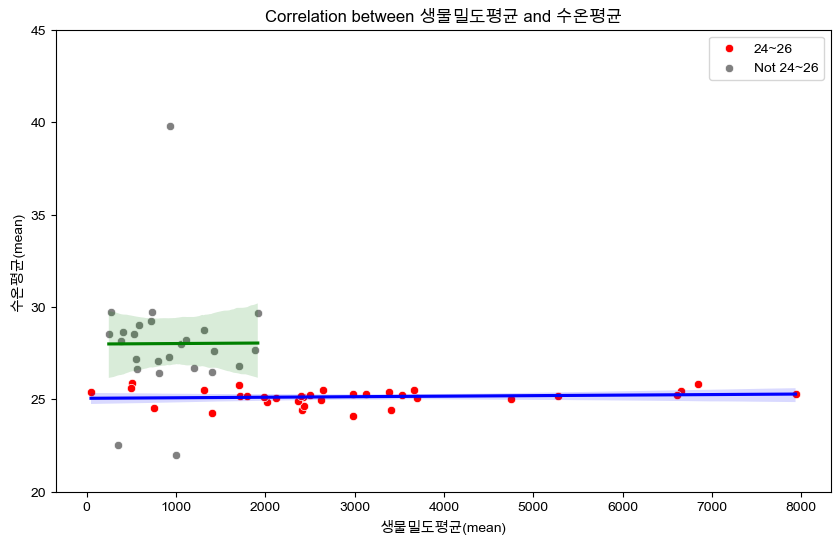

In [123]:

# 수온이 25~28 범주에 속하는 데이터
temp_24_26 = mean_data[(mean_data['수온평균(mean)'] >= 24) & (mean_data['수온평균(mean)'] <= 26)]
# 수온이 25~28 범주에 속하지 않는 데이터
temp_not_24_26 = mean_data[(mean_data['수온평균(mean)'] < 24) | (mean_data['수온평균(mean)'] > 26)]

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 산점도 그리기 (수온이 25~28 범주에 속하는 데이터)
sns.scatterplot(data=temp_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='red', label='24~26')

# 회귀선 그리기 (수온이 25~28 범주에 속하는 데이터)
sns.regplot(data=temp_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='blue', scatter=False)

# 산점도 그리기 (수온이 25~28 범주에 속하지 않는 데이터)
sns.scatterplot(data=temp_not_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='gray', label='Not 24~26')

# 회귀선 그리기 (수온이 25~28 범주에 속하지 않는 데이터)
sns.regplot(data=temp_not_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='green', scatter=False)

# 축 레이블과 제목 설정
plt.xlabel('생물밀도평균(mean)')
plt.ylabel('수온평균(mean)')
plt.title('Correlation between 생물밀도평균 and 수온평균')

# y축 범위 설정
plt.ylim(20,45)

# 범례 표시
plt.legend()

# 그래프 표시
plt.show()


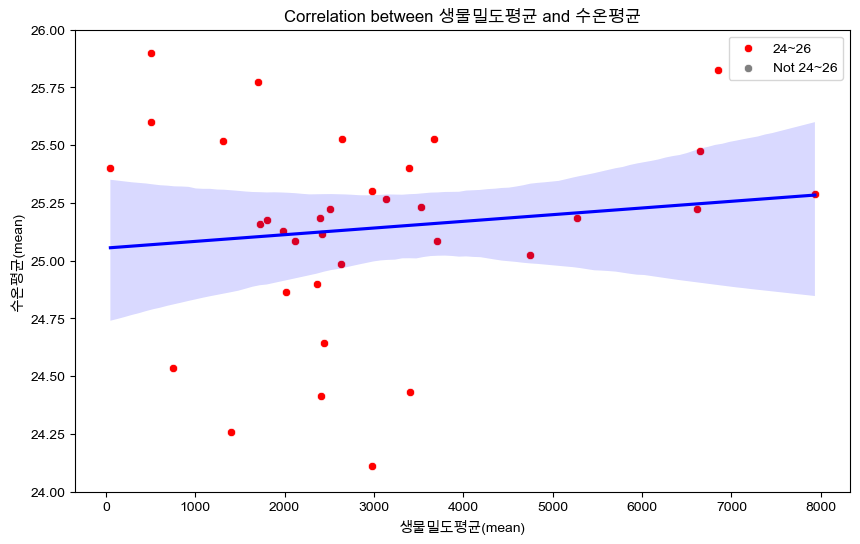

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수온이 25~28 범주에 속하는 데이터
temp_24_26 = mean_data[(mean_data['수온평균(mean)'] >= 24) & (mean_data['수온평균(mean)'] <= 26)]
# 수온이 25~28 범주에 속하지 않는 데이터
temp_not_24_26 = mean_data[(mean_data['수온평균(mean)'] < 24) | (mean_data['수온평균(mean)'] > 26)]

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 산점도 그리기 (수온이 25~28 범주에 속하는 데이터)
sns.scatterplot(data=temp_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='red', label='24~26')

# 회귀선 그리기 (수온이 25~28 범주에 속하는 데이터)
sns.regplot(data=temp_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='blue', scatter=False)

# 산점도 그리기 (수온이 25~28 범주에 속하지 않는 데이터)
sns.scatterplot(data=temp_not_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='gray', label='Not 24~26')

# 회귀선 그리기 (수온이 25~28 범주에 속하지 않는 데이터)
sns.regplot(data=temp_not_24_26, x='생물밀도평균(mean)', y='수온평균(mean)', color='green', scatter=False)

# 축 레이블과 제목 설정
plt.xlabel('생물밀도평균(mean)')
plt.ylabel('수온평균(mean)')
plt.title('Correlation between 생물밀도평균 and 수온평균')

# y축 범위 설정
plt.ylim(24, 26)

# 범례 표시
plt.legend()

# 그래프 표시
plt.show()



### 3) 년, 월을 고려한 발생 빈도 집계

In [127]:
# 발생날짜를 문자열로 변환
filtered_data['발생날짜'] = filtered_data['발생날짜'].astype(str)

# 년, 월, 일 컬럼 추가
mean_data['년'] = filtered_data['발생날짜'].str[:4]
mean_data['월'] = filtered_data['발생날짜'].str[5:7]
mean_data['일'] = filtered_data['발생날짜'].str[8:]
mean_data


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3260313753.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3260313753.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3260313753.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

생물밀도평균(mean)  수온평균(mean)       발생날짜     년   월   일
21      930.000000   39.800000 2018-08-09  2018  08  09
22      730.000000   29.700000 2018-08-08  2018  08  08
26      726.000000   29.260000 2018-08-07  2018  08  07
51      275.000000   29.750000 2018-08-06  2018  08  06
55      390.000000   28.166667 2018-08-05  2018  08  05
64      583.333333   29.033333 2018-08-04  2018  08  04
73     1053.333333   27.966667 2018-08-03  2018  08  03
82     1310.000000   28.775000 2018-08-02  2018  08  02
98     1115.000000   28.200000 2018-08-01  2018  08  01
134     917.600000   27.300000 2018-07-31  2018  07  31
159    1707.692308   26.807692 2018-07-30  2018  07  30
172    1423.333333   27.600000 2018-07-29  2018  07  29
181    1890.000000   27.650000 2018-07-28  2018  07  28
185    1916.666667   29.666667 2018-07-27  2018  07  27
194     405.000000   28.633333 2018-07-26  2018  07  26
203     526.666667   28.533333 2018-07-25  2018  07  25
212     249.000000   28.550000 2018-07-24  2018  07  24
228     555.500000   27.200000 2018-07-23  2018  07  23
324     355.000000   22.525000 2018-07-03  2018  07  03
503    2983.513514   24.113514 2015-09-09  2015  09  09
540    2410.000000   24.412500 2015-09-08  2015  09  08
604    3408.040000   24.430000 2015-09-07  2015  09  07
654    2628.571429   24.985714 2015-09-06  2015  09  06
703    2435.428571   24.642857 2015-09-05  2015  09  05
752    2647.750000   25.525000 2015-09-04  2015  09  04
816    5272.333333   25.183333 2015-09-03  2015  09  03
852    1721.428571   25.157143 2015-09-02  2015  09  02
901    2419.000000   25.116667 2015-09-01  2015  09  01
940    2016.666667   24.866667 2015-08-31  2015  08  31
976    3531.666667   25.233333 2015-08-30  2015  08  30
1012   1985.714286   25.128571 2015-08-29  2015  08  29
1061   2977.500000   25.300000 2015-08-28  2015  08  28
1125   3388.571429   25.400000 2015-08-27  2015  08  27
1174   2362.500000   24.900000 2015-08-26  2015  08  26
1247    753.333333   24.537500 2015-08-25  2015  08  25
1319   1798.888889   25.177778 2015-08-24  2015  08  24
1400   6845.000000   25.825000 2015-08-23  2015  08  23
1464   6653.750000   25.475000 2015-08-22  2015  08  22
1528   4750.000000   25.025000 2015-08-21  2015  08  21
1592   7935.000000   25.287500 2015-08-20  2015  08  20
1656   6611.750000   25.225000 2015-08-19  2015  08  19
1720   2505.750000   25.225000 2015-08-18  2015  08  18
1784   3667.500000   25.525000 2015-08-17  2015  08  17
1848   2395.333333   25.183333 2015-08-16  2015  08  16
1884   3131.000000   25.266667 2015-08-15  2015  08  15
1920   3702.500000   25.083333 2015-08-14  2015  08  14
1956   2120.000000   25.083333 2015-08-13  2015  08  13
2136   1400.000000   24.260000 2015-08-12  2015  08  12
2161   1199.500000   26.683333 2015-08-11  2015  08  11
2197   1403.500000   26.475000 2015-08-10  2015  08  10
2213    800.500000   27.066667 2015-08-09  2015  08  09
2249    811.666667   26.433333 2015-08-08  2015  08  08
2285   1309.200000   25.520000 2015-08-07  2015  08  07
2310   1705.000000   25.775000 2015-08-06  2015  08  06
2326    570.000000   26.625000 2015-08-05  2015  08  05
2342    505.000000   25.900000 2015-08-04  2015  08  04
2346    500.000000   25.600000 2015-08-03  2015  08  03
2347     50.000000   25.400000 2015-08-02  2015  08  02
2380   1000.000000   22.000000 2015-04-16  2015  04  16

In [128]:
import plotly.graph_objects as go

# Convert '발생날짜' column to datetime format
filtered_data['발생날짜'] = pd.to_datetime(filtered_data['발생날짜'])

# Extract year, month, and day from '발생날짜'
filtered_data['년'] = filtered_data['발생날짜'].dt.year
filtered_data['월'] = filtered_data['발생날짜'].dt.month
filtered_data['일'] = filtered_data['발생날짜'].dt.day

# Group the data by year, month, and day and calculate the mean values
grouped_data = filtered_data.groupby(['년', '월', '일']).mean().reset_index()

# Create a separate graph for each year
years = grouped_data['년'].unique()

for year in years:
    year_data = grouped_data[grouped_data['년'] == year]
    
    # Create the figure and add trace for density trend
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=year_data['월'].astype(str) + '-' + year_data['일'].astype(str),
                             y=year_data['생물밀도평균(max_mean)'],
                             mode='lines', name='생물밀도평균(max_mean)'))
    
    # Add trace for temperature trend
    fig.add_trace(go.Scatter(x=year_data['월'].astype(str) + '-' + year_data['일'].astype(str),
                             y=year_data['수온평균(max_mean)'],
                             mode='lines', name='수온평균(max_mean)'))
    
    # Configure the layout
    fig.update_layout(title=f'{year}년 생물밀도와 수온 추이',
                      xaxis_title='날짜',
                      yaxis_title='값')
    
    # Show the interactive plot
    fig.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3104828021.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3104828021.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\3104828021.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

KeyError: '생물밀도평균(max_mean)'

In [130]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Convert '발생날짜' column to datetime format
filtered_data['발생날짜'] = pd.to_datetime(filtered_data['발생날짜'])

# Extract year, month, and day from '발생날짜'
filtered_data['년'] = filtered_data['발생날짜'].dt.year
filtered_data['월'] = filtered_data['발생날짜'].dt.month
filtered_data['일'] = filtered_data['발생날짜'].dt.day

# Group the data by year, month, and day and calculate the mean values
grouped_data = filtered_data.groupby(['년', '월', '일']).mean().reset_index()

# Create a separate graph for each year
years = grouped_data['년'].unique()

for year in years:
    year_data = grouped_data[grouped_data['년'] == year]
    
    # Create subplots with one row and two columns
    fig = sp.make_subplots(rows=1, cols=2, shared_xaxes=True, subplot_titles=['생물밀도평균(mean)', '수온평균(max_mean)'])
    
    # Add trace for density trend
    fig.add_trace(go.Scatter(x=year_data['월'].astype(str) + '-' + year_data['일'].astype(str),
                             y=year_data['생물밀도평균(mean)'],
                             mode='lines', name='생물밀도평균(mean)'),
                  row=1, col=1)
    
    # Add trace for temperature trend
    fig.add_trace(go.Scatter(x=year_data['월'].astype(str) + '-' + year_data['일'].astype(str),
                             y=year_data['수온평균(mean)'],
                             mode='lines', name='수온평균(mean)'),
                  row=1, col=2)
    
    # Configure the left y-axis for density values
    fig.update_yaxes(title_text='생물밀도평균(mean)', row=1, col=1)
    
    # Configure the right y-axis for temperature values
    fig.update_yaxes(title_text='수온평균(mean)', row=1, col=2, side='right')
    
    # Configure the layout
    fig.update_layout(title=f'{year}년 생물밀도와 수온 추이',
                      xaxis_title='날짜')
    
    # Show the interactive plot
    fig.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\2081793062.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\2081793062.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\2081793062.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [240]:
# 발생날짜를 문자열로 변환
filtered_data['발생날짜'] = filtered_data['발생날짜'].astype(str)

# 년도별로 데이터프레임 분할
df_2015 = filtered_data[filtered_data['발생날짜'].str[:4] == '2015']
df_2016 = filtered_data[filtered_data['발생날짜'].str[:4] == '2016']
df_2017 = filtered_data[filtered_data['발생날짜'].str[:4] == '2017']
df_2018 = filtered_data[filtered_data['발생날짜'].str[:4] == '2018']
df_2017

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_19440\2697464442.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Empty DataFrame
Columns: [발생날짜, 조사해역, 원인생물, 생물밀도(max), 생물밀도(min), 수온(max), 수온(min), 속보코드, 시군구, 생물밀도평균(max_mean), 수온평균(max_mean), 년, 월, 일]
Index: []

## power 데이터 불러오기

In [131]:
import pandas as pd

# CSV 파일 불러오기
power_data = pd.read_csv(r"C:\Users\82103\Downloads\2013~2020.7 수요관리후 발전단 전력수요실적.csv", encoding='euc-kr')
power_df = power_data.copy()

# datetime 형식으로 날짜 변환
power_df['날짜'] = pd.to_datetime(power_df['날짜'])

# 날짜 필터링
filtered_power_df = power_df[(power_df['날짜'] >= '2015-01-01') & (power_df['날짜'] <= '2018-12-31')]

filtered_power_df.head()
filtered_power_df

날짜     1시     2시     3시     4시     5시     6시     7시     8시  \
730  2015-01-01  61559  59052  57215  56189  56118  56350  56363  54925   
731  2015-01-02  59110  56951  56294  55099  55153  56621  58350  61048   
732  2015-01-03  63969  61826  60235  59675  59499  60224  60745  60933   
733  2015-01-04  60728  58380  56588  55862  55784  55967  55987  55127   
734  2015-01-05  58160  55918  54847  54572  55289  56651  59473  63683   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
2186 2018-12-27  68421  65928  64545  64233  64837  66312  69256  74581   
2187 2018-12-28  71629  69118  67696  67046  67348  68649  71156  75946   
2188 2018-12-29  71171  68556  66738  65778  65437  65785  66706  67796   
2189 2018-12-30  67194  64591  62953  61943  61714  62189  62576  62613   
2190 2018-12-31  64534  62355  61091  60454  60660  61881  64304  68221   

         9시  ...    15시    16시    17시    18시    19시    20시    21시    22시  \
730   53384  ...  52225  52564  53488  56813  58839  58858  58769  58975   
731   65887  ...  67832  67357  68258  69180  69091  66684  65351  64078   
732   62524  ...  60482  60018  60079  61066  62011  61161  60546  60082   
733   54888  ...  53840  53908  54675  57300  59248  59237  59100  59325   
734   70855  ...  71777  70978  71535  71599  70413  68079  66205  64742   
...     ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
2186  82112  ...  80965  82193  84377  84031  81536  79060  76894  74545   
2187  83634  ...  81875  81844  82948  81986  79224  76783  75235  73363   
2188  69762  ...  66678  67083  68432  69526  69709  68974  68261  67206   
2189  62344  ...  60009  61050  62953  65950  67295  67146  66629  66097   
2190  73864  ...  70033  70123  70572  70564  69259  67725  66834  65806   

        23시    24시  
730   60815  61739  
731   65006  66579  
732   61362  63237  
733   60919  61203  
734   65104  66508  
...     ...    ...  
2186  73479  75147  
2187  72358  74217  
2188  67577  69678  
2189  66630  67154  
2190  65682  67920  

[1461 rows x 25 columns]

In [135]:
filtered_power_df['day_power'] = filtered_power_df.sum(axis=1)
filtered_power_df['day_power_mean'] = filtered_power_df.mean(axis=1)
filtered_power_df

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\300045390.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\300045390.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\300045390.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\300045390.py:2: SettingWithCopyWarning:


A value is try

날짜     1시     2시     3시     4시     5시     6시     7시     8시  \
730  2015-01-01  61559  59052  57215  56189  56118  56350  56363  54925   
731  2015-01-02  59110  56951  56294  55099  55153  56621  58350  61048   
732  2015-01-03  63969  61826  60235  59675  59499  60224  60745  60933   
733  2015-01-04  60728  58380  56588  55862  55784  55967  55987  55127   
734  2015-01-05  58160  55918  54847  54572  55289  56651  59473  63683   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
2186 2018-12-27  68421  65928  64545  64233  64837  66312  69256  74581   
2187 2018-12-28  71629  69118  67696  67046  67348  68649  71156  75946   
2188 2018-12-29  71171  68556  66738  65778  65437  65785  66706  67796   
2189 2018-12-30  67194  64591  62953  61943  61714  62189  62576  62613   
2190 2018-12-31  64534  62355  61091  60454  60660  61881  64304  68221   

         9시  ...    17시    18시    19시    20시    21시    22시    23시    24시  \
730   53384  ...  53488  56813  58839  58858  58769  58975  60815  61739   
731   65887  ...  68258  69180  69091  66684  65351  64078  65006  66579   
732   62524  ...  60079  61066  62011  61161  60546  60082  61362  63237   
733   54888  ...  54675  57300  59248  59237  59100  59325  60919  61203   
734   70855  ...  71535  71599  70413  68079  66205  64742  65104  66508   
...     ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
2186  82112  ...  84377  84031  81536  79060  76894  74545  73479  75147   
2187  83634  ...  82948  81986  79224  76783  75235  73363  72358  74217   
2188  69762  ...  68432  69526  69709  68974  68261  67206  67577  69678   
2189  62344  ...  62953  65950  67295  67146  66629  66097  66630  67154   
2190  73864  ...  70572  70564  69259  67725  66834  65806  65682  67920   

       day_power  day_power_mean  
730   2800819.84   163657.372308  
731   3194039.68   186633.975385  
732   3062300.80   178936.215385  
733   2832132.16   165487.012308  
734   3288586.08   192158.506154  
...          ...             ...  
2186  3778966.88   220812.413846  
2187  3823886.56   223437.158462  
2188  3394946.88   198373.375385  
2189  3161104.96   184709.535385  
2190  3371197.44   196985.649231  

[1461 rows x 27 columns]

In [133]:
daily_power = filtered_power_df[{'day_power','day_power_mean','날짜'}]
daily_power = daily_power[['날짜', 'day_power', 'day_power_mean']]
daily_power['날짜'] = pd.to_datetime(daily_power['날짜'])
daily_power['년'] = daily_power['날짜'].dt.year
daily_power['월'] = daily_power['날짜'].dt.month
daily_power['일'] = daily_power['날짜'].dt.day


daily_power

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9584\1081481406.py:1: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



날짜  day_power  day_power_mean     년   월   일
730  2015-01-01    1346548       107723.84  2015   1   1
731  2015-01-02    1535596       122847.68  2015   1   2
732  2015-01-03    1472260       117780.80  2015   1   3
733  2015-01-04    1361602       108928.16  2015   1   4
734  2015-01-05    1581051       126484.08  2015   1   5
...         ...        ...             ...   ...  ..  ..
2186 2018-12-27    1816811       145344.88  2018  12  27
2187 2018-12-28    1838407       147072.56  2018  12  28
2188 2018-12-29    1632186       130574.88  2018  12  29
2189 2018-12-30    1519762       121580.96  2018  12  30
2190 2018-12-31    1620768       129661.44  2018  12  31

[1461 rows x 6 columns]

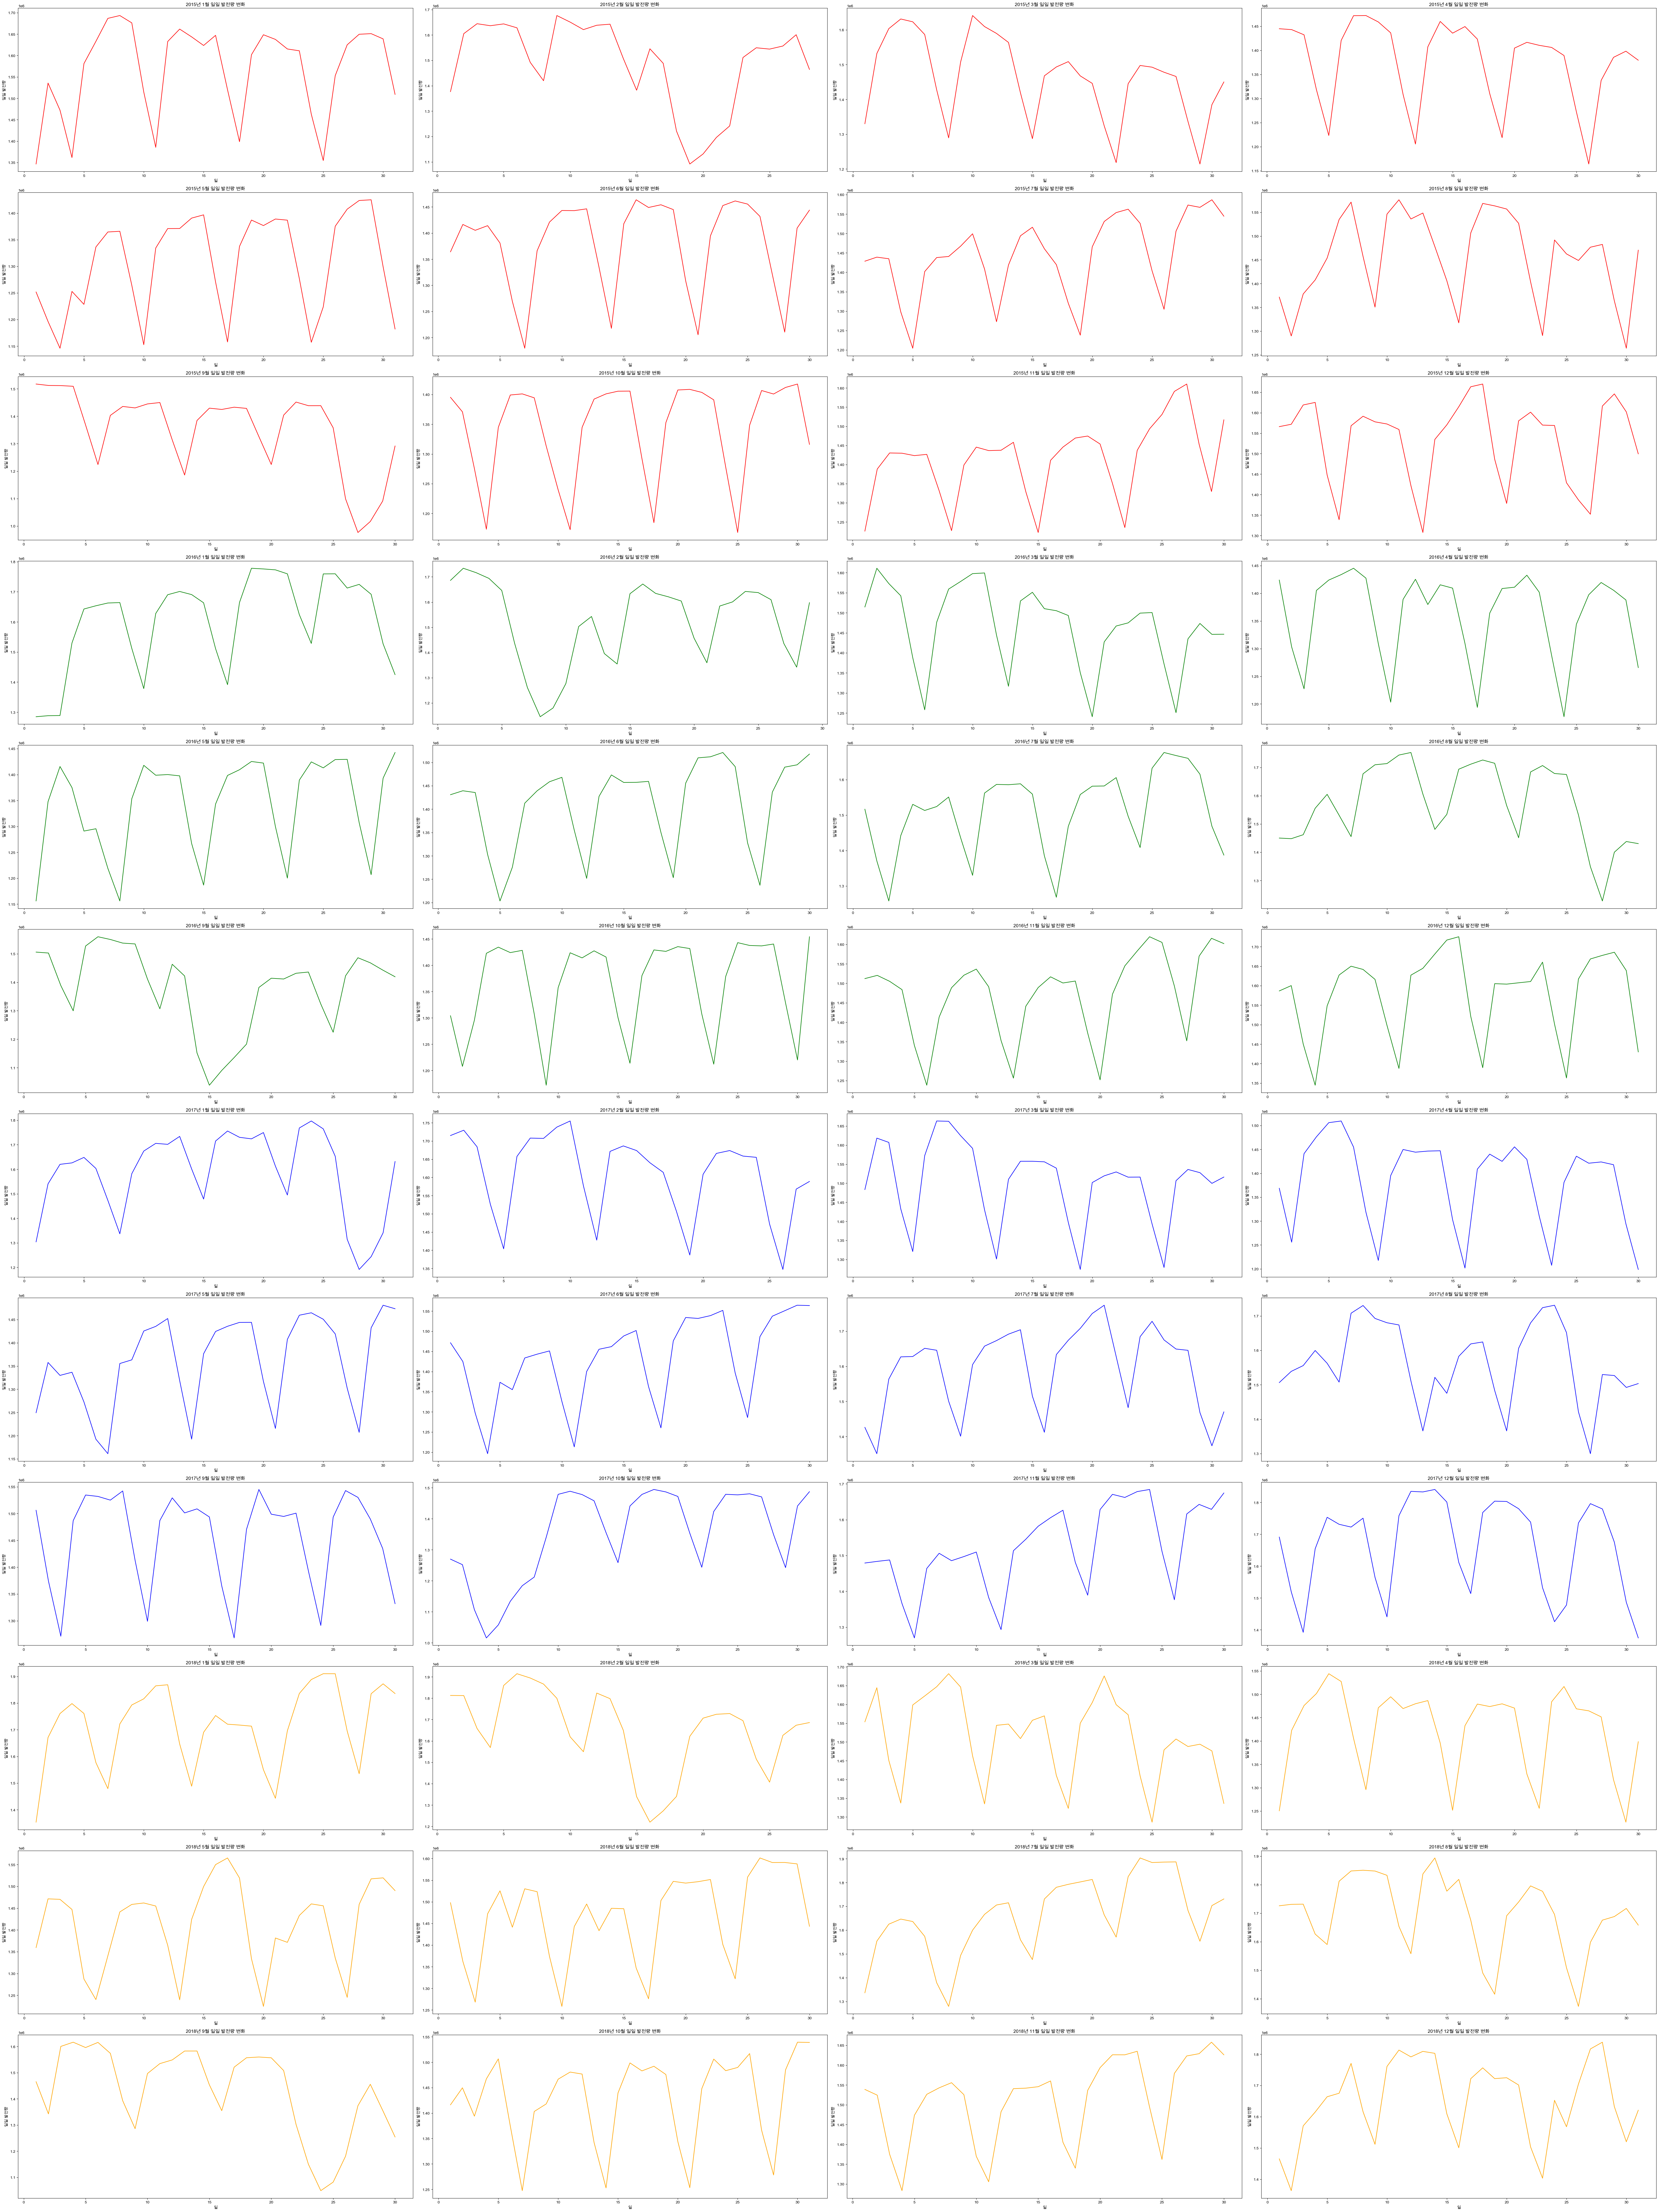

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# 각 연도와 월별로 데이터를 분할합니다.
years = daily_power['년'].unique()
months = daily_power['월'].unique()

# 48개의 프레임으로 그래프를 그립니다.
fig, axes = plt.subplots(12, 4, figsize=(60, 80))
axes = axes.flatten()

# 연도별 색상을 설정합니다.
colors = ['red', 'green', 'blue','orange']

for i, year in enumerate(years):
    for j, month in enumerate(months):
        ax = axes[i * 12 + j]
        month_data = daily_power[(daily_power['년'] == year) & (daily_power['월'] == month)]
        
        ax.plot(month_data['일'], month_data['day_power'], color=colors[i])
        ax.set_xlabel('일')
        ax.set_ylabel('일일 발전량')
        ax.set_title(f'{year}년 {month}월 일일 발전량 변화')

plt.tight_layout()
plt.show()

